In [1]:
import os
import time
import tarfile
import matplotlib.pyplot as plt
import pandas as pd
import torch
from pathlib import Path
from NeuralNMF import train
from sklearn.feature_extraction.text import TfidfVectorizer
from NeuralNMF import Neural_NMF
import pickle
import scipy.io
import random
import numpy as np
from scipy.ndimage import gaussian_filter1d

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)


In [ ]:
def NNMF(dataset,layers,day,mouse,timeframes = 3):
    """
    Neural Non-negative Matrix Factorization for optogenetic data analysis.
    
    This function performs hierarchical motif extraction from neural activity data
    and evaluates correspondence with optogenetic stimulation timing.
    """
    
    # === DATA LOADING ===
    # Extract neural activity matrix S (neurons x time) and optogenetic markers
    trainS = dataset["S"][0][day]  # Neural activity: neurons × timepoints
    opto = dataset["opt"][0][day]   # Optogenetic stimulation markers: binary vector
    
    # === ARCHITECTURE SETUP ===
    # Insert input dimension as first layer (neurons × timeframes)
    layers.insert(0,trainS.shape[0]*timeframes)
    
    # === TEMPORAL SEGMENTATION ===
    # Create overlapping time windows to capture temporal dynamics
    # This allows NMF to learn motifs that span multiple time points
    trainData = []
    for i in range(trainS.shape[1]-timeframes+1):
        segment = trainS[:,i:i+timeframes]           # Extract time window
        flatt = segment.flatten(order='F')           # Flatten using Fortran order (column-major)
        trainData.append(flatt)
    trainMatrix = np.array(trainData).T              # Transpose: features × samples
    
    # === NEURAL NMF TRAINING ===
    # Convert to PyTorch tensor and initialize Neural NMF network
    train__ = torch.tensor(trainMatrix)
    net = Neural_NMF(layers)                         # Initialize network with specified architecture
    # Train for 20 epochs with learning rate 500, unsupervised mode
    history = train(net, train__, epoch=20, lr=500, supervised=False)

    
    # === EXTRACT TRAINED MATRICES ===
    # Get the learned factorization matrices from training history
    A = history[0][len(layers)-2]                    # Higher-level basis matrix W²
    S = history[1][len(layers)-2]                    # Activation matrix H
    W1 = history[0][0].detach().numpy()              # Lower-level basis matrix W¹
    W = A.detach().numpy()                           # Convert W² to numpy
    H = S.detach().numpy()                           # Convert H to numpy
    
    # === OPTOGENETIC STIMULATION ANALYSIS ===
    # Identify stimulation onset times for response analysis
    opto = opto.flatten()                            # Ensure 1D array
    opto_extra = opto.copy()                         # Create copy to avoid modifying original
    # Detect stimulation onsets (rising edges from 0 to 1)
    opto_extra[1:] = np.diff(opto) == 1             # Find transitions from 0→1
    opto_extra[0] = opto[0]                          # Preserve first timepoint
    indices = np.where(opto_extra == 1)[0]          # Get indices of stimulation onsets
    
    # === EXTRACT POST-STIMULATION ACTIVITY ===
    # Collect H matrix segments following each stimulation
    slices = []
    for idx in indices:
        if idx + 20 <= H.shape[1]:                   # If full 20-timestep window available
            slices.append(H[:, idx:idx+20])          # Extract 20 timesteps post-stimulation
        else:
            slices.append(H[:, idx:])                # Extract remaining timesteps
    # Concatenate all post-stimulation segments for analysis
    H_segment = np.hstack(slices) if slices else np.array([])



    # === VISUALIZATION 1: LOWER-LEVEL BASIS MATRIX W¹ ===
    # This matrix shows how individual neurons contribute to lower-level motifs
    # Each column represents a motif, each row represents a neuron
    plt.figure(figsize=(8, 6))
    plt.imshow(W1, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label="Weight Value")  # Show color scale

    # Axis labels
    plt.xlabel("Lower Level Motifs", fontsize=14, fontweight='bold', fontname='Times New Roman')
    plt.ylabel("Neurons", fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Title for IEEE paper format
    plt.title(r'Heat Map of $W^{(1)}$', fontsize=16, fontweight='bold', fontname='Times New Roman')

    # Font settings for ticks
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')

    # Save figure with high resolution
    plt.savefig('W1.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()



    # === VISUALIZATION 2: HIGHER-LEVEL BASIS MATRIX W² ===
    # This matrix shows how lower-level motifs combine into higher-level patterns
    # Represents the hierarchical structure learned by the two-layer NMF
    plt.imshow(W, cmap='coolwarm', interpolation='nearest')
    cbar = plt.colorbar()
    cbar.set_label("Weight Value", fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Axis labels with proper formatting
    plt.xlabel("Higher Level Motifs", fontsize=14, fontweight='bold', fontname='Times New Roman')
    plt.ylabel("Lower Level Motifs", fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Title formatted for IEEE standard
    plt.title(r'Heat Map of $W^{(2)}$', fontsize=16, fontweight='bold', fontname='Times New Roman')

    # Improve tick labels readability
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')

    # Save high-resolution figure for IEEE paper
    plt.savefig('W.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()



    # === VISUALIZATION 3: ACTIVATION MATRIX H (POST-STIMULATION) ===
    # Shows temporal activation patterns of motifs following optogenetic stimulation
    # Only displays first 100 timepoints for clarity
    plt.figure(figsize=(10, 1))

    plt.imshow(H_segment[:, :100], cmap='coolwarm', interpolation='nearest', aspect='auto')

    # Colorbar with label
    # cbar = plt.colorbar()
    # cbar.set_label("Activation Value", fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Axis labels
    plt.xlabel("Time (Post-Stimulation)", fontsize=14, fontweight='bold', fontname='Times New Roman')
    plt.ylabel("Higher-Level Motifs", fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Title formatted for IEEE standard
    plt.title(r'Heat Map of $H$ Matrix (Post-Stimulation Activity)', fontsize=16, fontweight='bold', fontname='Times New Roman')

    # Improve tick labels readability
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')

    # Save high-resolution figure
    plt.savefig('H.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

    





    S2 = (A @ S).detach().numpy()

    # Extract slices based on indices
    slices = []
    for idx in indices:
        if idx + 20 <= S2.shape[1]:
            slices.append(S2[:, idx:idx+10])
        else:
            slices.append(S2[:, idx:])
    D = np.hstack(slices) if slices else np.array([])

    # Create figure with reduced vertical height
    plt.figure(figsize=(10, 3.5))  # Width = 10, Lower vertical height

    # Plot heatmap with adjusted aspect ratio
    plt.imshow(D[:, :150], cmap='coolwarm', interpolation='nearest', aspect=0.3)

    # Colorbar with label
    cbar = plt.colorbar()
    cbar.set_label("Activation Value", fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Axis Labels
    plt.xlabel("Time", fontsize=14, fontweight='bold', fontname='Times New Roman')
    plt.ylabel("Neural Activity", fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Title formatted for IEEE standard
    plt.title(r'Heatmap of $W^{(2)} \times H$', fontsize=16, fontweight='bold', fontname='Times New Roman')

    # Improve tick labels readability
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')

    # Save high-resolution figure
    plt.savefig('heatmap_W2_H.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()








    # === F1-SCORE ANALYSIS FOR MOTIF-STIMULATION CORRESPONDENCE ===
    # Evaluate how well each motif detects optogenetic stimulation events
    # across different activation thresholds
    
    thresholds = np.linspace(0, 0.15, 200)        # Range of activation thresholds to test

    # Find stimulation indices
    stimulation_indices = indices
    row_f1_scores = []

    # Calculate F1 Score for each threshold and each motif (row of H)
    for i, row in enumerate(H):
        f1_scores_for_row = []
        for threshold in thresholds:
            # === MOTIF DETECTION ===
            # Find all timepoints where motif activation exceeds threshold
            total_motifs_indices = np.where(row > threshold)[0]  # All motif activation indices
            stimulated_motifs_count = 0

            # === COUNT TRUE POSITIVES ===
            # Check if motif activations occur within 10 timesteps after stimulation
            for stim_idx in stimulation_indices:
                # Check for motif activations within post-stimulation window
                nearby_indices = total_motifs_indices[
                    (total_motifs_indices >= stim_idx) & (total_motifs_indices < stim_idx + 10)
                ]
                if len(nearby_indices) > 0:  # If motif is activated after stimulation
                    stimulated_motifs_count += 1

            # === CALCULATE PERFORMANCE METRICS ===
            # Precision: What fraction of detected motifs correspond to stimulations?
            precision = stimulated_motifs_count / len(total_motifs_indices) if len(total_motifs_indices) > 0 else 0
            # Recall: What fraction of stimulations trigger motif activation?
            recall = stimulated_motifs_count / len(stimulation_indices) if len(stimulation_indices) > 0 else 0

            # F1 Score: Harmonic mean of precision and recall
            if precision + recall > 0:
                f1_score = 2 * (precision * recall) / (precision + recall)
            else:
                f1_score = 0
            f1_scores_for_row.append(f1_score)
        
        # === SMOOTH F1 CURVES ===
        # Apply Gaussian filtering to reduce noise in F1-score curves
        smoothed_f1_scores = gaussian_filter1d(f1_scores_for_row, sigma=2)
        row_f1_scores.append(smoothed_f1_scores)


    # Convert F1 scores to NumPy array
    row_f1_scores = np.array(row_f1_scores)

    # Plot F1 Score vs Threshold for all rows on one graph
    plt.figure(figsize=(12, 8))
    for i in range(H.shape[0]):
        plt.plot(thresholds, row_f1_scores[i], label=f'Row {i}', linewidth=2)

    # Add graph details
    plt.title('F1 Score vs Threshold for All Rows', fontsize=16, weight='bold')
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('F1 Score', fontsize=14)
    plt.legend(title="Rows", loc="upper right", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Save the figure in high resolution for research purposes
    plt.savefig('f1_score_vs_threshold.png', dpi=300)

    # Show the plot
    plt.show()

    for row_index in range(H.shape[0]):
        row_values = H[row_index]

        # Plot the bar graph for the current row
        plt.figure(figsize=(7, 3))  # Smaller figure size
        plt.bar(range(len(row_values)), row_values, color='blue', edgecolor='none', width=2.5)

        # Add vertical lines for opto-stimulation
        for stim_idx in stimulation_indices:
            plt.axvline(x=stim_idx, color='red', linestyle='--', linewidth=0.35, label='Opto Stimulation' if stim_idx == stimulation_indices[0] else '')

        # Set the y-axis range dynamically based on the maximum value of the row
        max_y = max(row_values)
        plt.ylim(0, max_y * 1.1)  # Add 10% padding above the maximum value for better visualization

        # Add labels and title
        plt.title(f'Bar Graph of Values in Row {row_index} with Opto-Stimulation', fontsize=12)
        plt.xlabel('Column Index', fontsize=10)
        plt.ylabel('Value', fontsize=10)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        # Add legend
        plt.legend(fontsize=8, loc='upper right')

        # Tighten the layout for cleaner appearance
        plt.tight_layout()

        # Save the figure in high resolution for research purposes
        plt.savefig(f'row_{row_index}_bar_graph_with_vlines_smaller.png', dpi=300)

        # Show the plot
        plt.show()
    

    # return history,W,H,H_segment

    return history

100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


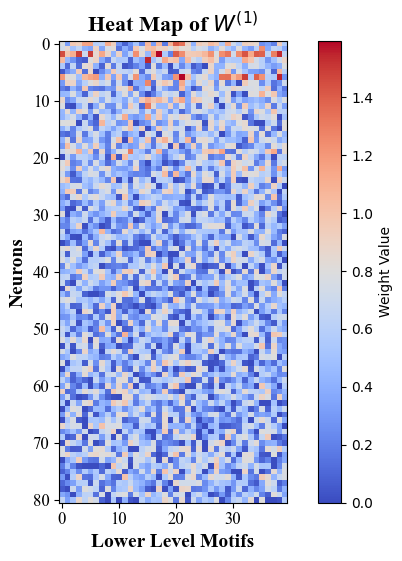

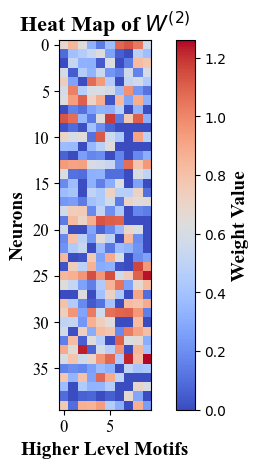

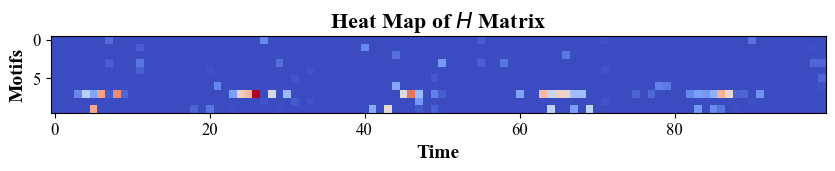

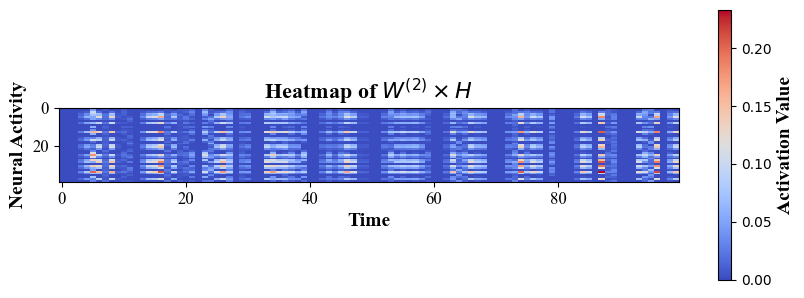

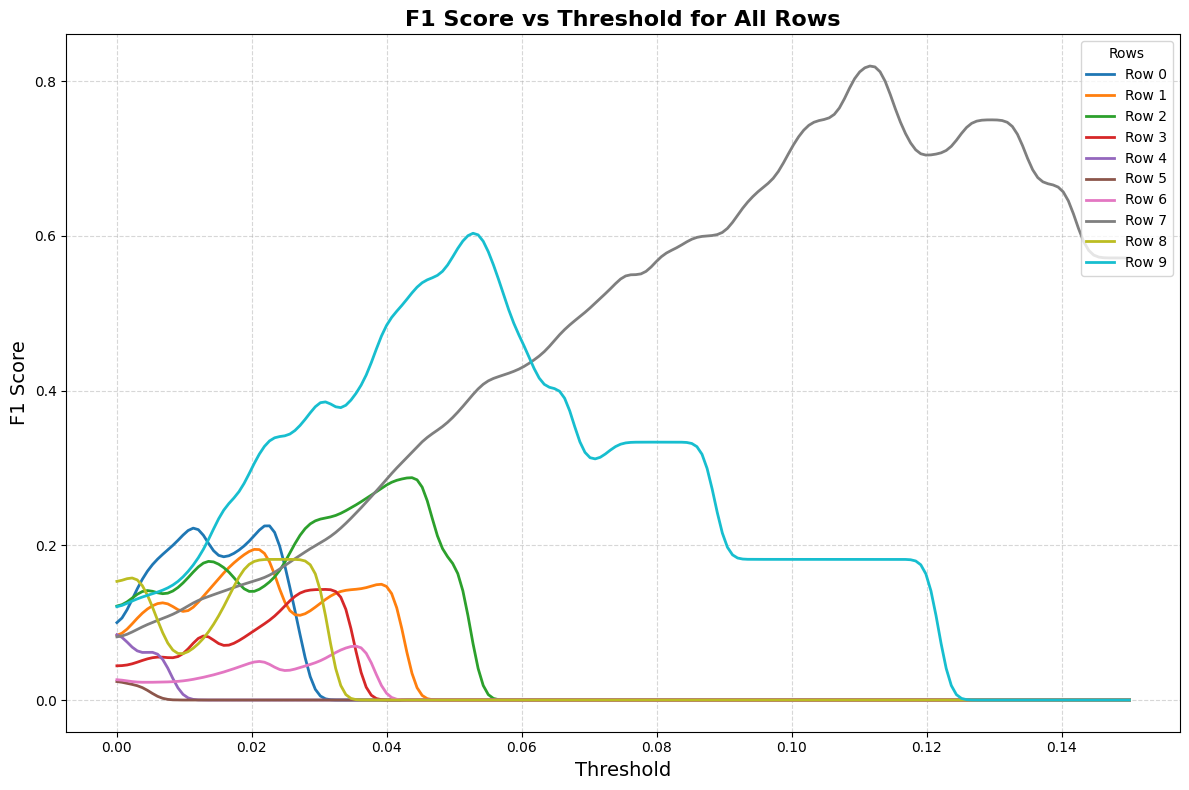

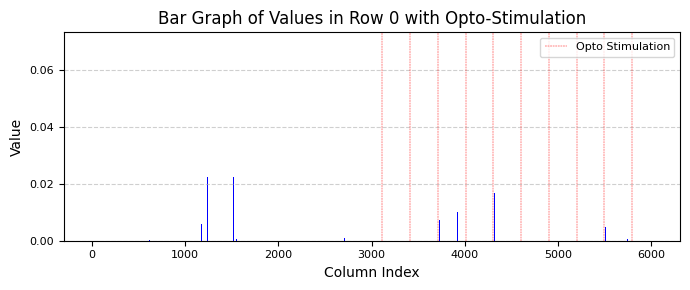

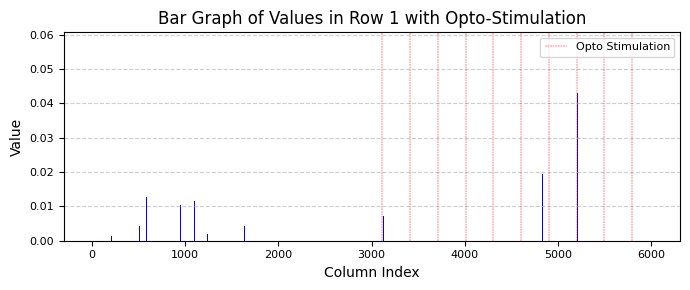

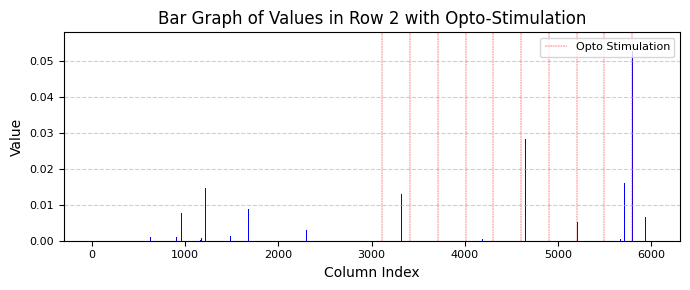

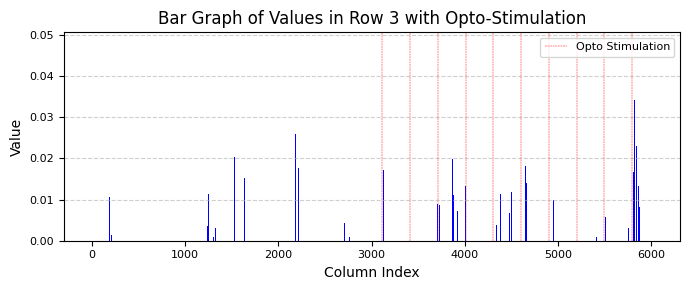

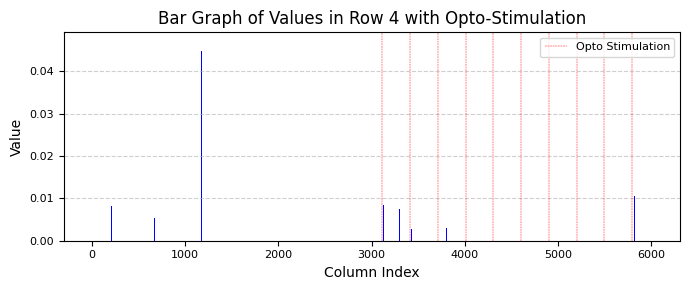

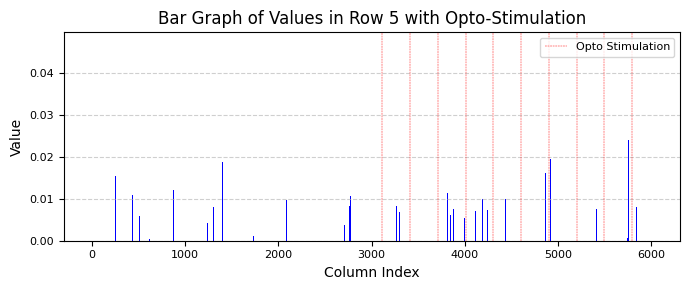

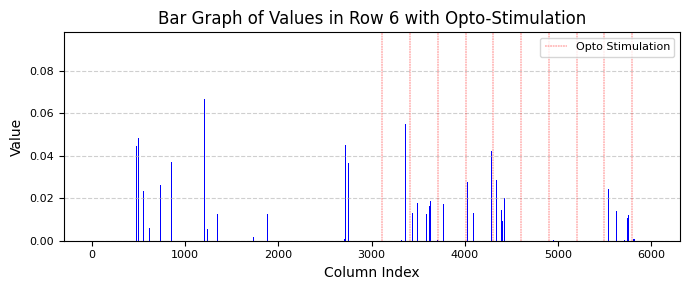

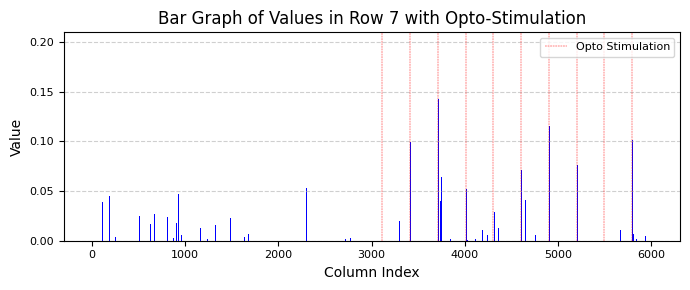

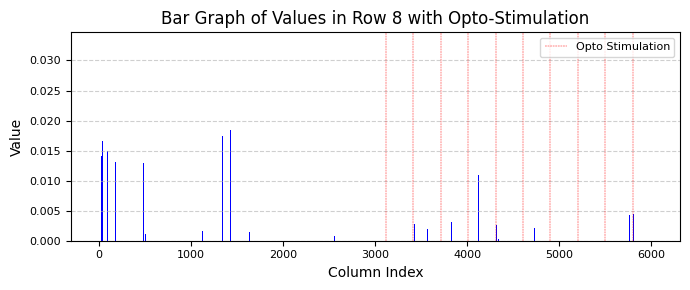

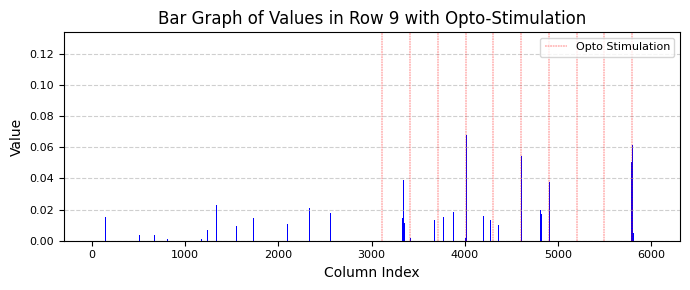

In [4]:
np.random.seed(7)
random.seed(7)
torch.manual_seed(7)
torch.use_deterministic_algorithms(True)

mouse = 18
mat_data = scipy.io.loadmat(rf"F:\RESEARCH\For_Tezuka\For_Tezuka\Opto_Data_CLa{mouse}.mat")
for day in range(1):
    timeframe = 1
    layers = [40, 10]
    # history, W, H, H_segment = NNMF(mat_data, layers, day, mouse, timeframe)
    history = NNMF(mat_data, layers, day, mouse, timeframe)

In [6]:
epoch_times = history[2]
epoch_times  

[1.3468410968780518,
 1.1446166038513184,
 1.1265385150909424,
 1.1503958702087402,
 1.130528211593628,
 1.12404203414917,
 1.1597027778625488,
 1.1027932167053223,
 1.0936405658721924,
 1.0988984107971191,
 1.0881760120391846,
 1.066873550415039,
 1.0864653587341309,
 1.077467441558838,
 1.098572015762329,
 1.076502799987793,
 1.0817022323608398,
 1.0886054039001465,
 1.0902090072631836,
 1.0670371055603027]

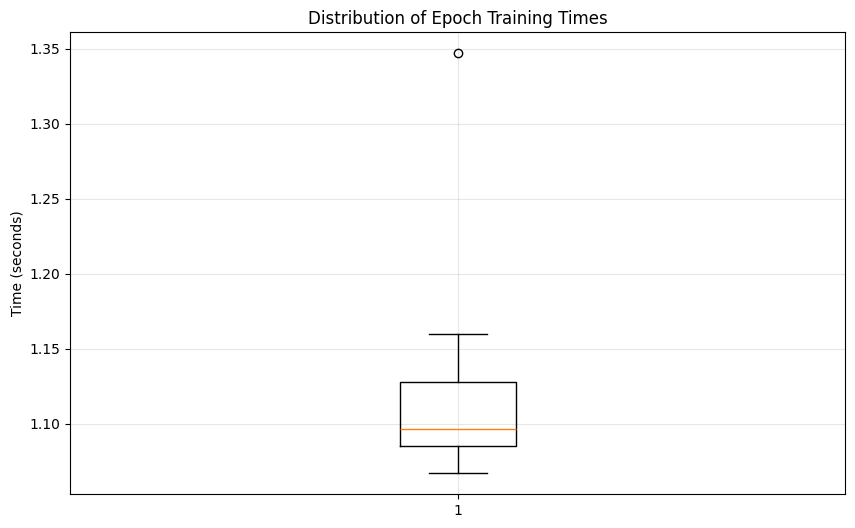

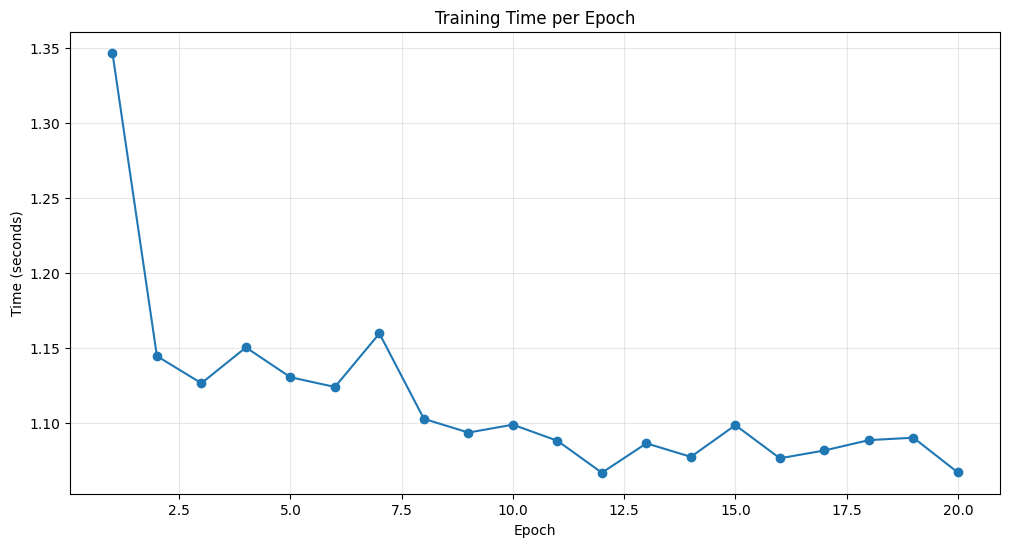

Average epoch time: 1.1150 seconds
Median epoch time: 1.0961 seconds
Minimum epoch time: 1.0669 seconds
Maximum epoch time: 1.3468 seconds
Standard deviation: 0.0596 seconds
Total training time: 22.2996 seconds


In [7]:
plt.figure(figsize=(10, 6))
plt.boxplot(epoch_times)
plt.title("Distribution of Epoch Training Times")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
plt.show()

# Create a line plot to show how training time evolves
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(epoch_times)+1), epoch_times, marker='o', linestyle='-')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and display statistics
print(f"Average epoch time: {np.mean(epoch_times):.4f} seconds")
print(f"Median epoch time: {np.median(epoch_times):.4f} seconds")
print(f"Minimum epoch time: {min(epoch_times):.4f} seconds")
print(f"Maximum epoch time: {max(epoch_times):.4f} seconds")
print(f"Standard deviation: {np.std(epoch_times):.4f} seconds")
print(f"Total training time: {sum(epoch_times):.4f} seconds")

In [14]:
def evaluate_hyperparameters(dataset, day, mouse, timeframes=1):
    """
    Evaluate different K1 and K2 configurations based on reconstruction loss.
    Generates a high-quality visualization for academic publication.
    """
    # Define hyperparameter ranges to test
    k1_values = [10, 20, 30, 40]
    k2_values = [2, 5, 10]
    
    reconstruction_losses = np.zeros((len(k1_values), len(k2_values)))
    
    trainS = dataset["S"][0][day]
    
    for i, k1 in enumerate(k1_values):
        for j, k2 in enumerate(k2_values):
            # Configure model layers
            layers = [trainS.shape[0]*timeframes, k1, k2]
            
            # Prepare data
            trainData = []
            for t in range(trainS.shape[1]-timeframes+1):
                segment = trainS[:, t:t+timeframes]
                flatt = segment.flatten(order='F')
                trainData.append(flatt)
            trainMatrix = np.array(trainData).T
            
            # Initialize and train model
            train__ = torch.tensor(trainMatrix)
            net = Neural_NMF(layers)
            A_lst, S_lst, epoch_times = train(net, train__, epoch=10, lr=500, supervised=False, full_history=False)
            
            # Compute reconstruction manually
            reconstructed = A_lst[0]
            for l in range(1, len(A_lst)):
                reconstructed = reconstructed @ A_lst[l]
            reconstructed = reconstructed @ S_lst[-1]
            
            # Calculate loss
            loss = torch.norm(train__ - reconstructed, p='fro')**2
            reconstruction_losses[i, j] = loss.item()
    
    # Normalize the reconstruction losses
    max_loss = np.max(reconstruction_losses)
    normalized_losses = reconstruction_losses / max_loss
    
    # Create publication-quality figure
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Set up the plot aesthetics with IEEE style in mind
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 12,
        'axes.linewidth': 1.2,
    })
    
    # Custom color palette with high contrast for readability
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    markers = ['o', 's', 'd']
    line_styles = ['-', '--', '-.']
    
    # Plot with enhanced styling
    for j, k2 in enumerate(k2_values):
        plt.plot(k1_values, normalized_losses[:, j], 
                 marker=markers[j], 
                 linestyle=line_styles[j],
                 linewidth=2.5, 
                 color=colors[j], 
                 markersize=10,
                 label=f'K₂={k2}')
    
    # Add grid with IEEE-appropriate styling
    plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.8)
    
    # Set labels with proper mathematical notation
    plt.xlabel('K₁ (Number of patterns in layer 1)', fontweight='bold', fontsize=14)
    plt.ylabel('Normalized Reconstruction Loss', fontweight='bold', fontsize=14)
    
    # Customize tick marks for readability
    plt.xticks(k1_values, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add legend with IEEE-appropriate styling
    legend = plt.legend(title="K₂ values", frameon=True, fontsize=12)
    legend.get_title().set_fontweight('bold')
    
    # Set tight layout for optimal use of space
    plt.tight_layout()
    
    # Set specific y-axis limit to focus on relevant changes
    y_min = np.min(normalized_losses) * 0.98
    y_max = 1.01
    plt.ylim(y_min, y_max)
    
    # Add a thin box around the plot area
    plt.box(True)
    
    # Save with high resolution
    plt.savefig('hyperparameter_selection1.png', dpi=300, bbox_inches='tight')
    
    return normalized_losses, k1_values, k2_values


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Best configuration: K1=10, K2=10, Loss=0.9133301218251882


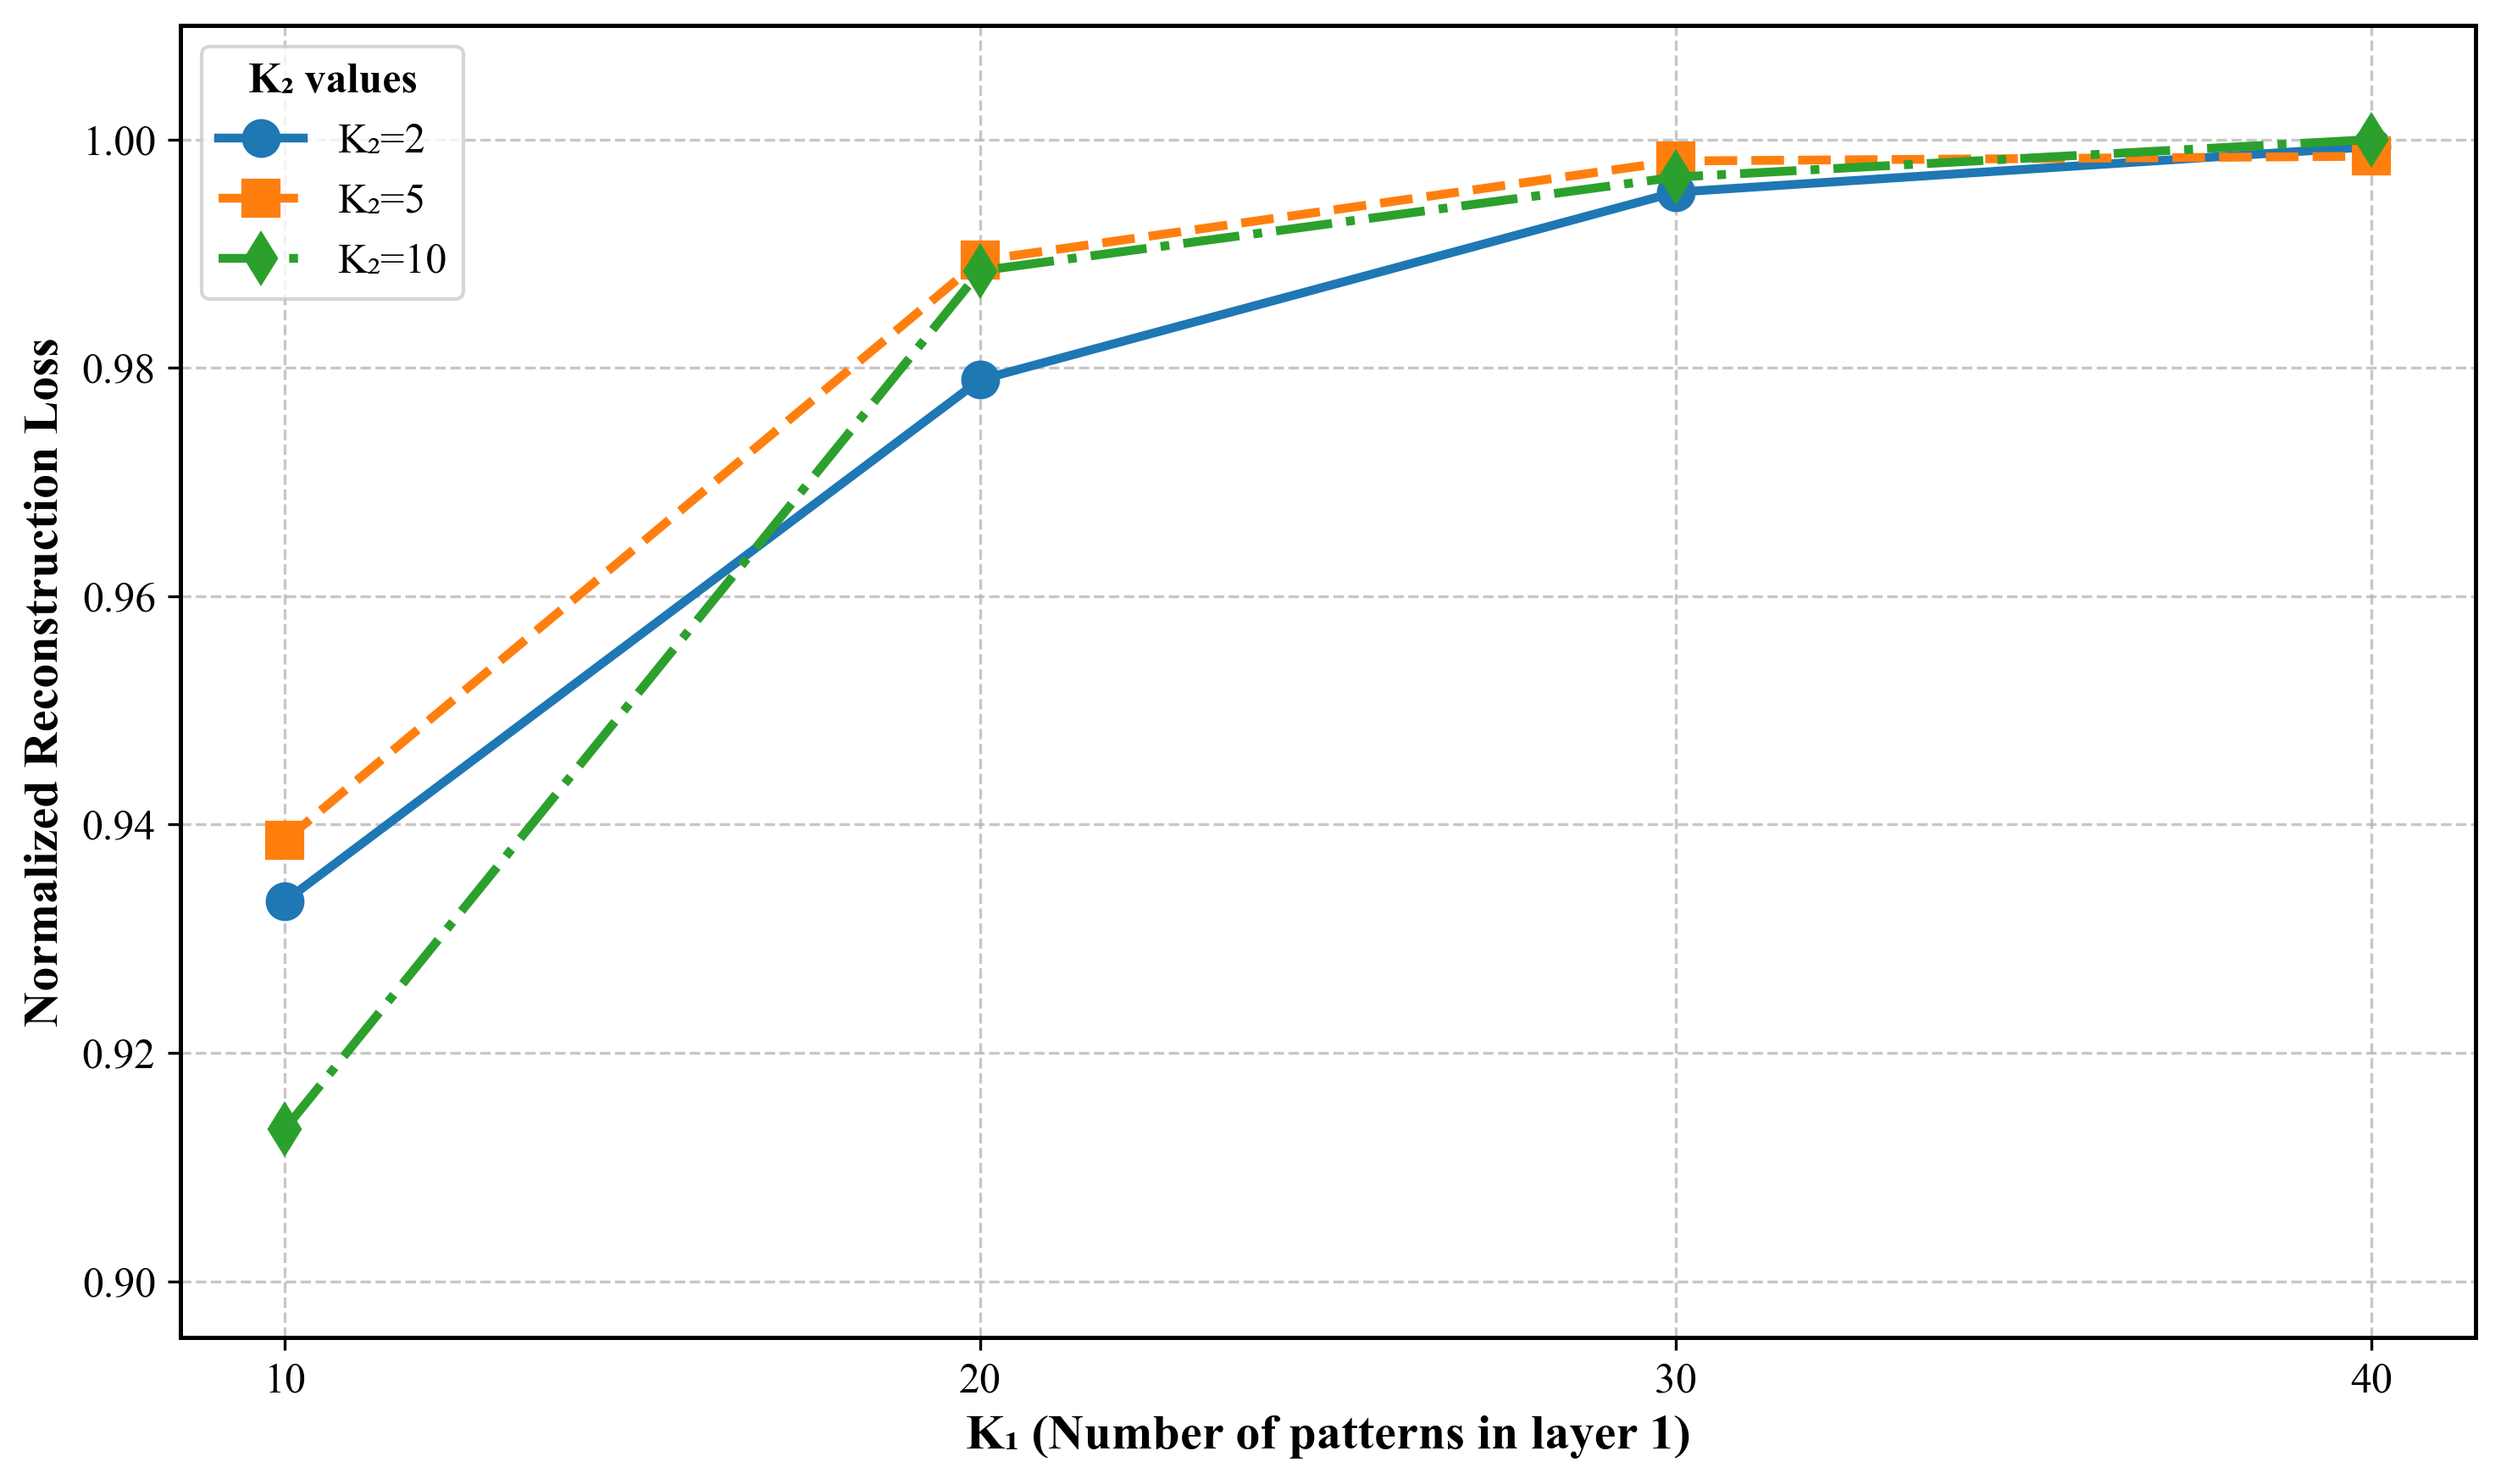

In [15]:
# Run the evaluation with your dataset
losses, k1s, k2s = evaluate_hyperparameters(mat_data, day=1, mouse=mouse, timeframes=1)

# To find the best configuration
best_i, best_j = np.unravel_index(np.argmin(losses), losses.shape)
print(f"Best configuration: K1={k1s[best_i]}, K2={k2s[best_j]}, Loss={losses[best_i, best_j]}")
